In [27]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import ternary

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.cluster import KMeans, SpectralClustering

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# solve the problem of "libdevice not found at ./libdevice.10.bc"
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/r10222035/.conda/envs/tf2'

In [28]:
# prepare fake data: three 5D Gaussian distributions

muA = [0, 0, 0, 0, 0]
covA = np.eye(5)
muB = [1, 1, 1, 1, 1]
covB = np.eye(5)
muC = [-1, -1, -1, -1, -1]
covC = np.eye(5)

case_name = 'ambiguous'

# set random seed
np.random.seed(24)

def generate_data(n_samples=10000):
    # # dominated case 1
    # f1A, f1B, f1C = 0.7, 0.2, 0.1
    # f2A, f2B, f2C = 0.1, 0.7, 0.2
    # f3A, f3B, f3C = 0.2, 0.1, 0.7

    # # dominated case 2
    # f1A, f1B, f1C = 0.80, 0.10, 0.10
    # f2A, f2B, f2C = 0.70, 0.25, 0.05
    # f3A, f3B, f3C = 0.60, 0.20, 0.20

    # ambiguous case 
    f1A, f1B, f1C = 0.80, 0.10, 0.10
    f2A, f2B, f2C = 0.70, 0.20, 0.10
    f3A, f3B, f3C = 0.60, 0.25, 0.15
    
    fractions = np.array([[f1A, f1B, f1C], [f2A, f2B, f2C], [f3A, f3B, f3C]])

    # normalize fractions
    fractions = fractions / fractions.sum(axis=1)[:, None]

    n_A_1, n_B_1, n_C_1 = (fractions[0] * n_samples).astype(int)
    n_A_2, n_B_2, n_C_2 = (fractions[1] * n_samples).astype(int)
    n_A_3, n_B_3, n_C_3 = (fractions[2] * n_samples).astype(int)
    
    M1 = np.concatenate([np.random.multivariate_normal(muA, covA, size=n_A_1),
                         np.random.multivariate_normal(muB, covB, size=n_B_1),
                         np.random.multivariate_normal(muC, covC, size=n_C_1)])
    
    M2 = np.concatenate([np.random.multivariate_normal(muA, covA, size=n_A_2),
                            np.random.multivariate_normal(muB, covB, size=n_B_2),
                            np.random.multivariate_normal(muC, covC, size=n_C_2)])
    
    M3 = np.concatenate([np.random.multivariate_normal(muA, covA, size=n_A_3),
                            np.random.multivariate_normal(muB, covB, size=n_B_3),
                            np.random.multivariate_normal(muC, covC, size=n_C_3)])
    
    X = np.concatenate([M1, M2, M3])
    # one-hot encoding
    y = np.concatenate([np.tile([1, 0, 0], (M1.shape[0], 1)),
                        np.tile([0, 1, 0], (M2.shape[0], 1)),
                        np.tile([0, 0, 1], (M3.shape[0], 1))])
    
    y_true = np.concatenate([np.tile([1, 0, 0], (n_A_1, 1)),
                             np.tile([0, 1, 0], (n_B_1, 1)),
                             np.tile([0, 0, 1], (n_C_1, 1)),
                             np.tile([1, 0, 0], (n_A_2, 1)),
                             np.tile([0, 1, 0], (n_B_2, 1)),
                             np.tile([0, 0, 1], (n_C_2, 1)),
                             np.tile([1, 0, 0], (n_A_3, 1)),
                             np.tile([0, 1, 0], (n_B_3, 1)),
                             np.tile([0, 0, 1], (n_C_3, 1))])


    return X, y, y_true

In [29]:
n_test = 1000
X_test = np.concatenate([np.random.multivariate_normal(muA, covA, size=n_test), 
                         np.random.multivariate_normal(muB, covB, size=n_test),
                         np.random.multivariate_normal(muC, covC, size=n_test)])
y_test = np.concatenate([np.tile([1, 0, 0], (n_test, 1)),
                         np.tile([0, 1, 0], (n_test, 1)),
                         np.tile([0, 0, 1], (n_test, 1))])

In [30]:
# buile multi-class classification model
def build_model(input_dim, n_class=3):
    model = Sequential()
    model.add(Dense(8, input_dim=input_dim, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(n_class, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

In [31]:
class MyTestingCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        super(MyTestingCallback, self).__init__()
        self.test_data = test_data
        self.testing_loss = []
        self.testing_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        # Test on another dataset
        results = self.model.evaluate(x=self.test_data[0], y=self.test_data[1], batch_size=1024)
        self.testing_loss.append(results[0])
        print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

        # Compute ACC
        y_pred = self.model.predict(self.test_data[0], batch_size=1024)
        ACC = get_highest_accuracy(self.test_data[1], y_pred)
        self.testing_accuracy.append(ACC)
        print(f'True ACC: Testing Loss = {results[0]:.3}, Testing Accuracy = {ACC:.3}')

def get_highest_accuracy(y_true, y_pred):
    _, _, thresholds = roc_curve(y_true, y_pred)
    # compute highest accuracy
    thresholds = np.array(thresholds)
    if len(thresholds) > 1000:
        thresholds = np.percentile(thresholds, np.linspace(0, 100, 1001))
    accuracy_scores = []
    for threshold in thresholds:
        accuracy_scores.append(accuracy_score(y_true, y_pred>threshold))

    accuracies = np.array(accuracy_scores)
    return accuracies.max()

In [32]:
def plot_event_distribution(X, y, y_true, save_path=None):
    if X.shape[0] > 400:
        idx = np.random.choice(X.shape[0], 400, replace=False)
        X = X[idx]
        y = y[idx]
        y_true = y_true[idx]

    y = np.argmax(y, axis=1)
    y_true = np.argmax(y_true, axis=1)

    # plot the event distribution
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    ax[0].scatter(X[(y==0) & (y_true==0)][:, 0], X[(y==0) & (y_true==0)][:, 1], c='b', marker='x', alpha=0.3, label='$M_1$')
    ax[0].scatter(X[(y==1) & (y_true==0)][:, 0], X[(y==1) & (y_true==0)][:, 1], c='r', marker='+', alpha=0.3, label='$M_2$')
    ax[0].scatter(X[(y==2) & (y_true==0)][:, 0], X[(y==2) & (y_true==0)][:, 1], c='g', marker='o', alpha=0.3, label='$M_3$')
    ax[0].legend(frameon=False)
    ax[0].set_title('Class $A$')
    ax[0].set_xlabel('Feature 1')
    ax[0].set_ylabel('Feature 2')

    ax[0].set_xlim(-4, 6)
    ax[0].set_ylim(-4, 6)


    ax[1].scatter(X[(y==0) & (y_true==1)][:, 0], X[(y==0) & (y_true==1)][:, 1], c='b', marker='x', alpha=0.3, label='$M_1$')
    ax[1].scatter(X[(y==1) & (y_true==1)][:, 0], X[(y==1) & (y_true==1)][:, 1], c='r', marker='+', alpha=0.3, label='$M_2$')
    ax[1].scatter(X[(y==2) & (y_true==1)][:, 0], X[(y==2) & (y_true==1)][:, 1], c='g', marker='o', alpha=0.3, label='$M_3$')
    ax[1].legend(frameon=False)
    ax[1].set_title('Class $B$')
    ax[1].set_xlabel('Feature 1')
    ax[1].set_ylabel('Feature 2')

    ax[1].set_xlim(-4, 6)
    ax[1].set_ylim(-4, 6)

    ax[2].scatter(X[(y==0) & (y_true==2)][:, 0], X[(y==0) & (y_true==2)][:, 1], c='b', marker='x', alpha=0.3, label='$M_1$')
    ax[2].scatter(X[(y==1) & (y_true==2)][:, 0], X[(y==1) & (y_true==2)][:, 1], c='r', marker='+', alpha=0.3, label='$M_2$')
    ax[2].scatter(X[(y==2) & (y_true==2)][:, 0], X[(y==2) & (y_true==2)][:, 1], c='g', marker='o', alpha=0.3, label='$M_3$')
    ax[2].legend(frameon=False)
    ax[2].set_title('Class $C$')
    ax[2].set_xlabel('Feature 1')
    ax[2].set_ylabel('Feature 2')

    ax[2].set_xlim(-4, 6)
    ax[2].set_ylim(-4, 6)


    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='White', bbox_inches='tight')
    plt.show()

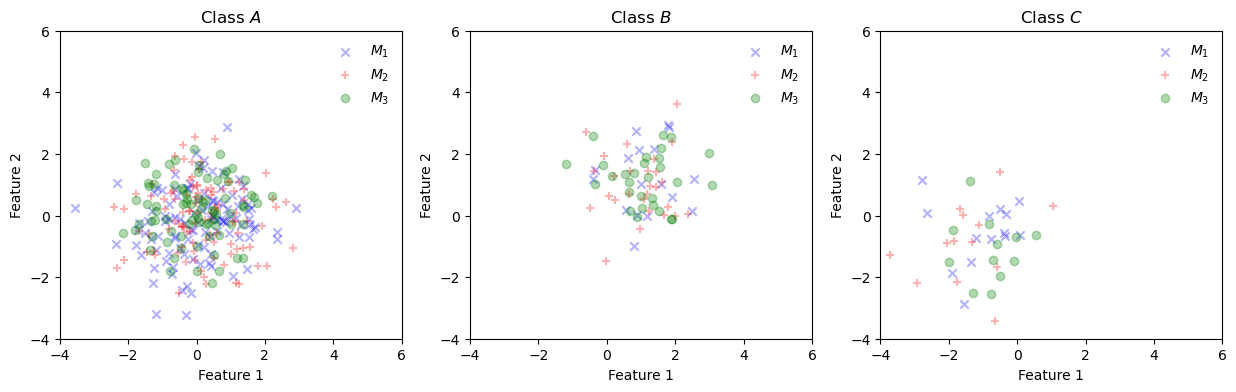

In [33]:
X_train, y_train, y_true = generate_data()
X_val, y_val, y_true_val = generate_data(n_samples=1000)

save_path = f'./figures/multi-class_training_data-{case_name}.pdf'
plot_event_distribution(X_train, y_train, y_true, save_path)

In [34]:
import numpy as np

# 原始一維陣列
original_array = np.array([0, 1, 2, 0, 1, 2])

# 定義映射規則 (以陣列形式表示)
mappings = np.array([
    [0, 1, 2],  # 原始
    [0, 2, 1],  # 0->0, 1->2, 2->1
    [2, 1, 0],  # 0->2, 1->1, 2->0
    [1, 0, 2],  # 0->1, 1->0, 2->2
    [2, 0, 1],  # 0->2, 1->0, 2->1
    [1, 2, 0],  # 0->1, 1->2, 2->0
])

# 使用 NumPy 高效映射
all_arrays = mappings[:, original_array]

# 輸出所有結果
for i, arr in enumerate(all_arrays, 1):
    print(f"陣列 {i}: {arr}")


陣列 1: [0 1 2 0 1 2]
陣列 2: [0 2 1 0 2 1]
陣列 3: [2 1 0 2 1 0]
陣列 4: [1 0 2 1 0 2]
陣列 5: [2 0 1 2 0 1]
陣列 6: [1 2 0 1 2 0]


In [35]:
def plot_event_score_distribution(y, y_score, y_predict_label=None, dataset='train', save_path=None):
    
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)

    if y_predict_label is None:
        y_predict_label = y_score.argmax(axis=1)

    # 定義映射規則 (以陣列形式表示)
    mappings = np.array([
        [0, 1, 2],  # 原始
        [0, 2, 1],  # 0->0, 1->2, 2->1
        [2, 1, 0],  # 0->2, 1->1, 2->0
        [1, 0, 2],  # 0->1, 1->0, 2->2
        [2, 0, 1],  # 0->2, 1->0, 2->1
        [1, 2, 0],  # 0->1, 1->2, 2->0
    ])

    # 使用 NumPy 高效映射
    all_arrays = mappings[:, y_predict_label]

    ACC = 0
    # 輸出所有結果
    for i, arr in enumerate(all_arrays, 1):
        ACC_tem = (y == arr).mean()
        if ACC_tem > ACC:
            ACC = ACC_tem
            y_predict_label = arr

    ACC = (y == y_predict_label).mean()
    
    ACCs = []
    for i in range(3):
        ACCs.append((y[y == i] == y_predict_label[y == i]).mean())

    print(f'ACC: {ACC:.3f}, ACCs: {ACCs}') 

    if y.shape[0] > 400:
        idx = np.random.choice(y.shape[0], 400, replace=False)
        y = y[idx]
        y_score = y_score[idx]

    # 畫 event score 的分布
    if dataset == 'train':
        labels = ['$M_1$', '$M_2$', '$M_3$']
        title = 'Training set'
    elif dataset == 'test':
        labels = ['$A$', '$B$', '$C$']
        title = 'Testing set'

    # 設定繪圖範圍
    figure, tax = ternary.figure(scale=1)
    tax.set_title(f'{title}: ACC = {ACC:.3f}', fontsize=15)

    # 設定軸標籤
    tax.bottom_axis_label('Event score 1', fontsize=12, offset=0.2)
    tax.right_axis_label('Event score 2', fontsize=12)
    tax.left_axis_label('Event score 3', fontsize=12)

    # 生成主導區域的分界線點
    # 這些線表示當某個組分等於其他組分時的情況
    line_points_A = [(1/3, 1/3, 1/3), (0.5, 0.5, 0)]  # A = B > C
    line_points_B = [(1/3, 1/3, 1/3), (0, 0.5, 0.5)]  # B = C > A
    line_points_C = [(1/3, 1/3, 1/3), (0.5, 0, 0.5)]  # A = C > B

    # 繪製分界線
    tax.plot([line_points_A[0], line_points_A[1]], linewidth=2, color='grey', linestyle='--')
    tax.plot([line_points_B[0], line_points_B[1]], linewidth=2, color='grey', linestyle='--')
    tax.plot([line_points_C[0], line_points_C[1]], linewidth=2, color='grey', linestyle='--')
    
    # 添加區域標籤
    tax.annotate('1', (0.6, 0.12, 0.28), fontsize=50, alpha= 0.5, color='grey')
    tax.annotate('2', (0.2, 0.52, 0.28), fontsize=50, alpha= 0.5, color='grey')
    tax.annotate('3', (0.2, 0.12, 0.68), fontsize=50, alpha= 0.5, color='grey')

    # 繪製數據點
    tax.scatter(y_score[y == 0], marker='x', color='b', alpha=0.3, label=f'{labels[0]}: ACC = {ACCs[0]:.3f}')
    tax.scatter(y_score[y == 1], marker='+', color='r', alpha=0.3, label=f'{labels[1]}: ACC = {ACCs[1]:.3f}')
    tax.scatter(y_score[y == 2], marker='o', color='g', alpha=0.3, label=f'{labels[2]}: ACC = {ACCs[2]:.3f}')

    # 設置樣式
    tax.boundary(linewidth=2.0)
    tax.gridlines(multiple=0.1, color="gray")

    # 添加刻度
    tax.ticks(axis='lbr', multiple=0.2, linewidth=1, offset=0.03, tick_formats="%.1f")

    # 移除外部邊框
    tax.get_axes().spines['top'].set_visible(False)
    tax.get_axes().spines['right'].set_visible(False)
    tax.get_axes().spines['bottom'].set_visible(False)
    tax.get_axes().spines['left'].set_visible(False)

    # 添加圖例
    tax.legend(frameon=False)

    # 確保圖形緊湊
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('equal')

    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='White', bbox_inches='tight')
        
    # 顯示圖形
    plt.tight_layout()
    plt.show()

In [36]:
def plot_clustering_results(y, y_score, y_predict_label=None, title='Clustering', save_path=None):
    
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)

    if y_predict_label is None:
        y_predict_label = y_score.argmax(axis=1)

    # 定義映射規則 (以陣列形式表示)
    mappings = np.array([
        [0, 1, 2],  # 原始
        [0, 2, 1],  # 0->0, 1->2, 2->1
        [2, 1, 0],  # 0->2, 1->1, 2->0
        [1, 0, 2],  # 0->1, 1->0, 2->2
        [2, 0, 1],  # 0->2, 1->0, 2->1
        [1, 2, 0],  # 0->1, 1->2, 2->0
    ])

    # 使用 NumPy 高效映射
    all_arrays = mappings[:, y_predict_label]

    ACC = 0
    # 輸出所有結果
    for i, arr in enumerate(all_arrays, 1):
        ACC_tem = (y == arr).mean()
        if ACC_tem > ACC:
            ACC = ACC_tem
            y_predict_label = arr

    ACC = (y == y_predict_label).mean()
    
    ACCs = []
    for i in range(3):
        ACCs.append((y[y == i] == y_predict_label[y == i]).mean())

    ACC_argmax = (y == y_score.argmax(axis=1)).mean()
    
    ACCs_argmax = []
    for i in range(3):
        ACCs_argmax.append((y[y == i] == y_score.argmax(axis=1)[y == i]).mean())

    if y.shape[0] > 400:
        idx = np.random.choice(y.shape[0], 400, replace=False)
        y = y[idx]
        y_score = y_score[idx]
        y_predict_label = y_predict_label[idx]

    # plot the clustering result
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    xlim = y_score[:, 0].min(), y_score[:, 0].max()
    ylim = y_score[:, 1].min(), y_score[:, 1].max()

    ax[0].scatter(y_score[(y == 0) & (y_score.argmax(axis=1) == 0)][:, 0], y_score[(y == 0) & (y_score.argmax(axis=1) == 0)][:, 1], c='b', marker='$A$', label=' ')
    ax[0].scatter(y_score[(y == 0) & (y_score.argmax(axis=1) == 1)][:, 0], y_score[(y == 0) & (y_score.argmax(axis=1) == 1)][:, 1], c='r', marker='$A$', label=' ')
    ax[0].scatter(y_score[(y == 0) & (y_score.argmax(axis=1) == 2)][:, 0], y_score[(y == 0) & (y_score.argmax(axis=1) == 2)][:, 1], c='g', marker='$A$', label=' ')
    ax[0].scatter(y_score[(y == 1) & (y_score.argmax(axis=1) == 0)][:, 0], y_score[(y == 1) & (y_score.argmax(axis=1) == 0)][:, 1], c='b', marker='$B$', label=' ')
    ax[0].scatter(y_score[(y == 1) & (y_score.argmax(axis=1) == 1)][:, 0], y_score[(y == 1) & (y_score.argmax(axis=1) == 1)][:, 1], c='r', marker='$B$', label=' ')
    ax[0].scatter(y_score[(y == 1) & (y_score.argmax(axis=1) == 2)][:, 0], y_score[(y == 1) & (y_score.argmax(axis=1) == 2)][:, 1], c='g', marker='$B$', label=' ')
    ax[0].scatter(y_score[(y == 2) & (y_score.argmax(axis=1) == 0)][:, 0], y_score[(y == 2) & (y_score.argmax(axis=1) == 0)][:, 1], c='b', marker='$C$', label=' ')
    ax[0].scatter(y_score[(y == 2) & (y_score.argmax(axis=1) == 1)][:, 0], y_score[(y == 2) & (y_score.argmax(axis=1) == 1)][:, 1], c='r', marker='$C$', label=' ')
    ax[0].scatter(y_score[(y == 2) & (y_score.argmax(axis=1) == 2)][:, 0], y_score[(y == 2) & (y_score.argmax(axis=1) == 2)][:, 1], c='g', marker='$C$', label=' ')
    
    # plot boundary lines
    ax[0].plot([1/3, 0.5], [1/3, 0.5], linewidth=2, color='grey', linestyle='--')
    ax[0].plot([1/3, 0.0], [1/3, 0.5], linewidth=2, color='grey', linestyle='--')
    ax[0].plot([1/3, 0.5], [1/3, 0.0], linewidth=2, color='grey', linestyle='--')

    ax[0].set_title(f'Max argument: ACC = {ACC_argmax:.3f}')
    ax[0].set_xlabel('Event score 1')
    ax[0].set_ylabel('Event score 2')
    ax[0].set_xlim(xlim)
    ax[0].set_ylim(ylim)

    handles, labels = ax[0].get_legend_handles_labels()
    n = 3
    handles = [(handles[i * n], handles[i * n + 1], handles[i * n + 2]) for i in range(n)]
    labels = [f'ACC = {ACCs_argmax[0]:.3f}', f'ACC = {ACCs_argmax[1]:.3f}', f'ACC = {ACCs_argmax[2]:.3f}']
    handler_map = {tuple: plt.matplotlib.legend_handler.HandlerTuple(ndivide=None)}
    ax[0].legend(handles, labels, handler_map=handler_map, frameon=False)

    ax[1].scatter(y_score[(y == 0) & (y_predict_label == 0)][:, 0], y_score[(y == 0) & (y_predict_label == 0)][:, 1], c='b', marker='$A$', label=f' ')
    ax[1].scatter(y_score[(y == 0) & (y_predict_label == 1)][:, 0], y_score[(y == 0) & (y_predict_label == 1)][:, 1], c='r', marker='$A$', label=f' ')
    ax[1].scatter(y_score[(y == 0) & (y_predict_label == 2)][:, 0], y_score[(y == 0) & (y_predict_label == 2)][:, 1], c='g', marker='$A$', label=f' ')
    ax[1].scatter(y_score[(y == 1) & (y_predict_label == 0)][:, 0], y_score[(y == 1) & (y_predict_label == 0)][:, 1], c='b', marker='$B$', label=f' ')
    ax[1].scatter(y_score[(y == 1) & (y_predict_label == 1)][:, 0], y_score[(y == 1) & (y_predict_label == 1)][:, 1], c='r', marker='$B$', label=f' ')
    ax[1].scatter(y_score[(y == 1) & (y_predict_label == 2)][:, 0], y_score[(y == 1) & (y_predict_label == 2)][:, 1], c='g', marker='$B$', label=f' ')
    ax[1].scatter(y_score[(y == 2) & (y_predict_label == 0)][:, 0], y_score[(y == 2) & (y_predict_label == 0)][:, 1], c='b', marker='$C$', label=f' ')
    ax[1].scatter(y_score[(y == 2) & (y_predict_label == 1)][:, 0], y_score[(y == 2) & (y_predict_label == 1)][:, 1], c='r', marker='$C$', label=f' ')
    ax[1].scatter(y_score[(y == 2) & (y_predict_label == 2)][:, 0], y_score[(y == 2) & (y_predict_label == 2)][:, 1], c='g', marker='$C$', label=f' ')

    # plot boundary lines
    ax[1].plot([1/3, 0.5], [1/3, 0.5], linewidth=2, color='grey', linestyle='--')
    ax[1].plot([1/3, 0.0], [1/3, 0.5], linewidth=2, color='grey', linestyle='--')
    ax[1].plot([1/3, 0.5], [1/3, 0.0], linewidth=2, color='grey', linestyle='--')

    ax[1].set_title(f'{title}: ACC = {ACC:.3f}')
    ax[1].set_xlabel('Event score 1')
    ax[1].set_ylabel('Event score 2')
    ax[1].set_xlim(xlim)
    ax[1].set_ylim(ylim)

    handles, labels = ax[1].get_legend_handles_labels()
    n = 3
    handles = [(handles[i * n], handles[i * n + 1], handles[i * n + 2]) for i in range(3)]
    labels = [f'ACC = {ACCs[0]:.3f}', f'ACC = {ACCs[1]:.3f}', f'ACC = {ACCs[2]:.3f}']
    handler_map = {tuple: plt.matplotlib.legend_handler.HandlerTuple(ndivide=None)}
    ax[1].legend(handles, labels, handler_map=handler_map, frameon=False)

    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='White', bbox_inches='tight')

    plt.show()

M1: A: 8000, B: 1000, C: 1000
M2: A: 7000, B: 2000, C: 1000
M3: A: 6000, B: 2500, C: 1500
Epoch 1/50
30/30 [==============================] - 1s 10ms/step - loss: 1.1310 - accuracy: 0.3363 - val_loss: 1.1027 - val_accuracy: 0.3353
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 1.0960 - accuracy: 0.3537 - val_loss: 1.0961 - val_accuracy: 0.3387
Epoch 3/50
30/30 [==============================] - 0s 7ms/step - loss: 1.0928 - accuracy: 0.3605 - val_loss: 1.0942 - val_accuracy: 0.3643
Epoch 4/50
30/30 [==============================] - 0s 7ms/step - loss: 1.0918 - accuracy: 0.3685 - val_loss: 1.0933 - val_accuracy: 0.3593
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 1.0913 - accuracy: 0.3697 - val_loss: 1.0931 - val_accuracy: 0.3703
Epoch 6/50
30/30 [==============================] - 0s 7ms/step - loss: 1.0907 - accuracy: 0.3718 - val_loss: 1.0930 - val_accuracy: 0.3720
Epoch 7/50
30/30 [==============================] - 0s 7ms/step - los

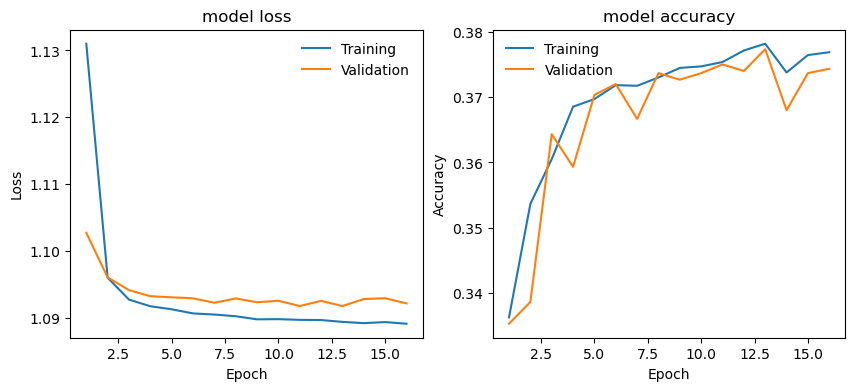

30/30 [==============================] - 0s 1ms/step
ACC: 0.380, ACCs: [0.64, 0.105, 0.3946]


/home/r10222035/.conda/envs/tf2/lib/python3.8/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


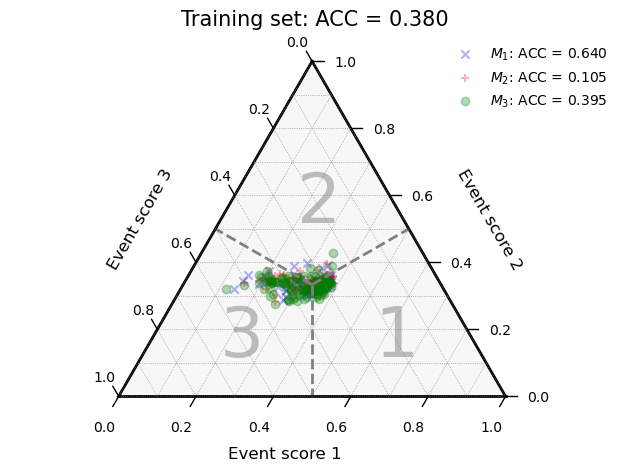

30/30 [==============================] - 0s 2ms/step - loss: 1.0886 - accuracy: 0.3799
Training Loss = 1.09, Training Accuracy = 0.38
3/3 [==============================] - 0s 2ms/step
ACC: 0.552, ACCs: [0.777, 0.109, 0.769]


/home/r10222035/.conda/envs/tf2/lib/python3.8/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


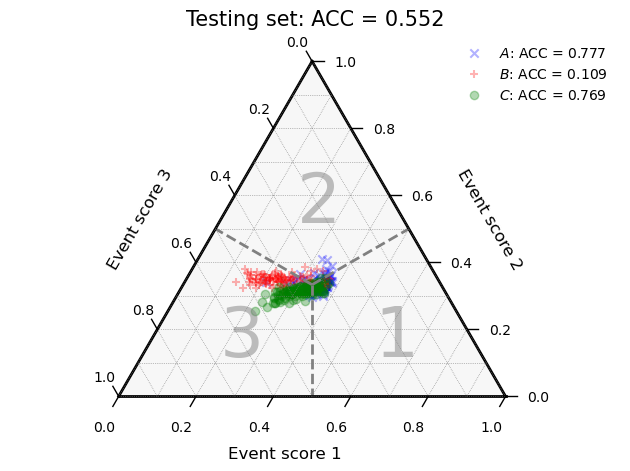

3/3 [==============================] - 0s 3ms/step - loss: 1.0340 - accuracy: 0.5517
Testing Loss = 1.03, Testing Accuracy = 0.552


In [37]:
# 檢查每個類別的數量
n_A_1 = np.sum(y_true[y_train.argmax(axis=1) == 0].argmax(axis=1) == 0)
n_B_1 = np.sum(y_true[y_train.argmax(axis=1) == 0].argmax(axis=1) == 1)
n_C_1 = np.sum(y_true[y_train.argmax(axis=1) == 0].argmax(axis=1) == 2)
n_A_2 = np.sum(y_true[y_train.argmax(axis=1) == 1].argmax(axis=1) == 0)
n_B_2 = np.sum(y_true[y_train.argmax(axis=1) == 1].argmax(axis=1) == 1)
n_C_2 = np.sum(y_true[y_train.argmax(axis=1) == 1].argmax(axis=1) == 2)
n_A_3 = np.sum(y_true[y_train.argmax(axis=1) == 2].argmax(axis=1) == 0)
n_B_3 = np.sum(y_true[y_train.argmax(axis=1) == 2].argmax(axis=1) == 1)
n_C_3 = np.sum(y_true[y_train.argmax(axis=1) == 2].argmax(axis=1) == 2)
print(f'M1: A: {n_A_1}, B: {n_B_1}, C: {n_C_1}')
print(f'M2: A: {n_A_2}, B: {n_B_2}, C: {n_C_2}')
print(f'M3: A: {n_A_3}, B: {n_B_3}, C: {n_C_3}')


# 建立模型並訓練
model = build_model(X_train.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=5)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=1024, verbose=1, 
                    callbacks=[
                                early_stopping,
                                # testing_callback,
                            ])

# plot the training loss, accuracy
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

x = range(1, len(history.history['loss']) + 1)

ax[0].plot(x, history.history['loss'], label='Training')
ax[0].plot(x, history.history['val_loss'], label='Validation')


ax[0].legend(frameon=False)
ax[0].set_title(f'model loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(x, history.history['accuracy'], label='Training')
ax[1].plot(x, history.history['val_accuracy'], label='Validation')


ax[1].legend(frameon=False)
ax[1].set_title(f'model accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()


y_predict = model.predict(X_train, batch_size=1024)

# plot the event score distribution
save_path = f'./figures/multi-class_training_data_score-{case_name}.pdf'
plot_event_score_distribution(y_train, y_predict, dataset='train', save_path=save_path)

results = model.evaluate(x=X_train, y=y_train, batch_size=1024)
print(f'Training Loss = {results[0]:.3}, Training Accuracy = {results[1]:.3}')

# plot the event score distribution
y_test_predict = model.predict(X_test, batch_size=1024)

# 畫 event score 的分布
save_path = f'./figures/multi-class_testing_data_score-{case_name}.pdf'
plot_event_score_distribution(y_test, y_test_predict, dataset='test', save_path=save_path)

results = model.evaluate(x=X_test, y=y_test, batch_size=1024)
print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

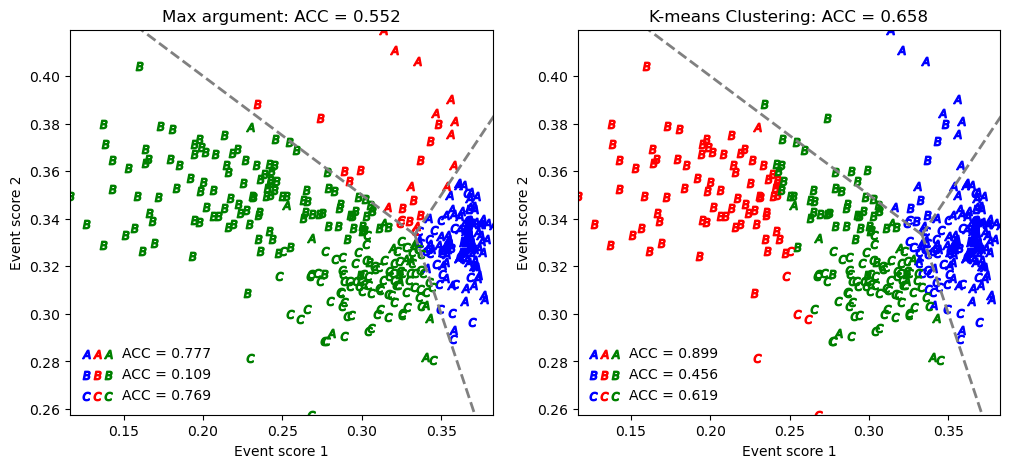

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=45)
kmeans.fit(y_test_predict)
labels = kmeans.labels_

plot_clustering_results(y_test, y_test_predict, labels, title='K-means Clustering')

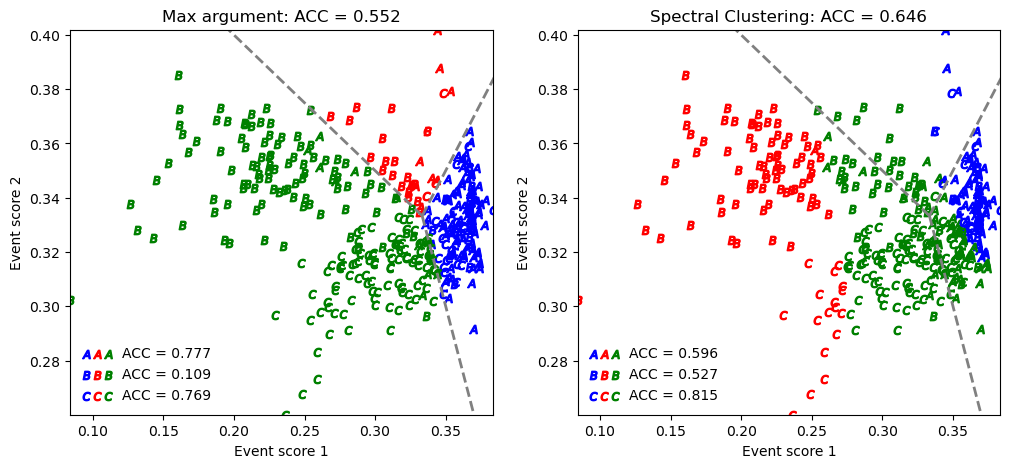

In [39]:
spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=45)
labels = spectral.fit_predict(y_test_predict)

plot_clustering_results(y_test, y_test_predict, labels, title='Spectral Clustering')